# Avaliação dos resultados detalhada
Avaliação no conjunto de testes para modelo Mask R-CNN treinado com fine-tuning, backbone ResNet-101 e imagem de entrada de tamanho 512 x 512.  

Dataset: CarDD [https://cardd-ustc.github.io]  
  
Referências: 
- guia do FiftyOne: [https://docs.voxel51.com/user_guide/evaluation.htm]
- notebook de exemplo de avaliação de detecção de objetos com o FiftyOne: [https://colab.research.google.com/github/voxel51/fiftyone/blob/v0.8.0/docs/source/tutorials/evaluate_detections.ipynb]

In [18]:
import fiftyone as fo
import fiftyone.utils.coco as fouc
from fiftyone import ViewField as F
from pathlib import Path
import sklearn.metrics as skm
import pandas as pd

## Leitura do conjunto de testes e suas anotações

In [19]:
# caminho da pasta com as imagens do conjunto de testes
data_path = "/home/s825860045/Datasets/CarDD_release/CarDD_COCO/test2017"
# caminho do arquivo com as anotações do conjunto de testes
labels_path = "/home/s825860045/Datasets/CarDD_release/CarDD_COCO/annotations/instances_test2017.json"

In [20]:
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    label_field="ground_truth",
    label_types="segmentations",
    include_id=True
)

 100% |█████████████████| 374/374 [1.8s elapsed, 0s remaining, 210.3 samples/s]         


In [21]:
classes = dataset.default_classes

# adiciona e popula o field image_id em todos os samples do dataset, com mesmo valor que havia no JSON de anotação
for sample in dataset.iter_samples(progress=True):
    sample["image_id"] = int(Path(sample.filepath).stem)
    sample.save()

 100% |█████████████████| 374/374 [2.1s elapsed, 0s remaining, 171.3 samples/s]      


In [22]:
# Compute metadata so we can reference image height/width in our view
dataset.compute_metadata()

# Adiciona ao dataset campo com o valor da àrea da máscara
for sample in dataset:
    frame_size = (sample.metadata.width, sample.metadata.height)
    for detection in sample.ground_truth_segmentations.detections:
        instance = detection.to_polyline()
        detection["area"] = instance.to_shapely(frame_size=frame_size).area

    sample.save()

In [23]:
dataset

Name:        2024.02.15.17.19.51
Media type:  image
Num samples: 374
Persistent:  False
Tags:        []
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_coco_id:       fiftyone.core.fields.IntField
    image_id:                   fiftyone.core.fields.IntField

In [24]:
# Quantidade de objetos no ground truth
counts = dataset.count_values("ground_truth_segmentations.detections.label")
print('Quantidade total de instâncias no ground truth: {}'.format(sum(list(counts.values()))))
counts

Quantidade total de instâncias no ground truth: 785


{'crack': 70,
 'lamp broken': 69,
 'tire flat': 32,
 'scratch': 307,
 'dent': 236,
 'glass shatter': 71}

## Adiciona as predições ao dataset do FiftyOne

In [25]:
# caminho do arquivo de resultados (predições para o conjunto de teste) para o modelo 512 x 512 Resnet101 com fine-tuning
predictions_file_path = "/home/s825860045/Projetos/TCC/car-damage-segmentation/analise-resultados/predictions_512_Resnet101.json"

fouc.add_coco_labels(
    dataset,
    "predictions",
    predictions_file_path,
    classes,
    label_type="segmentations",
    coco_id_field="ground_truth_coco_id" # O parâmetro coco_id_field especifica o campo usado para mapear predicao <-> sample
)

In [26]:
dataset

Name:        2024.02.15.17.19.51
Media type:  image
Num samples: 374
Persistent:  False
Tags:        []
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_coco_id:       fiftyone.core.fields.IntField
    image_id:                   fiftyone.core.fields.IntField
    predictions:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


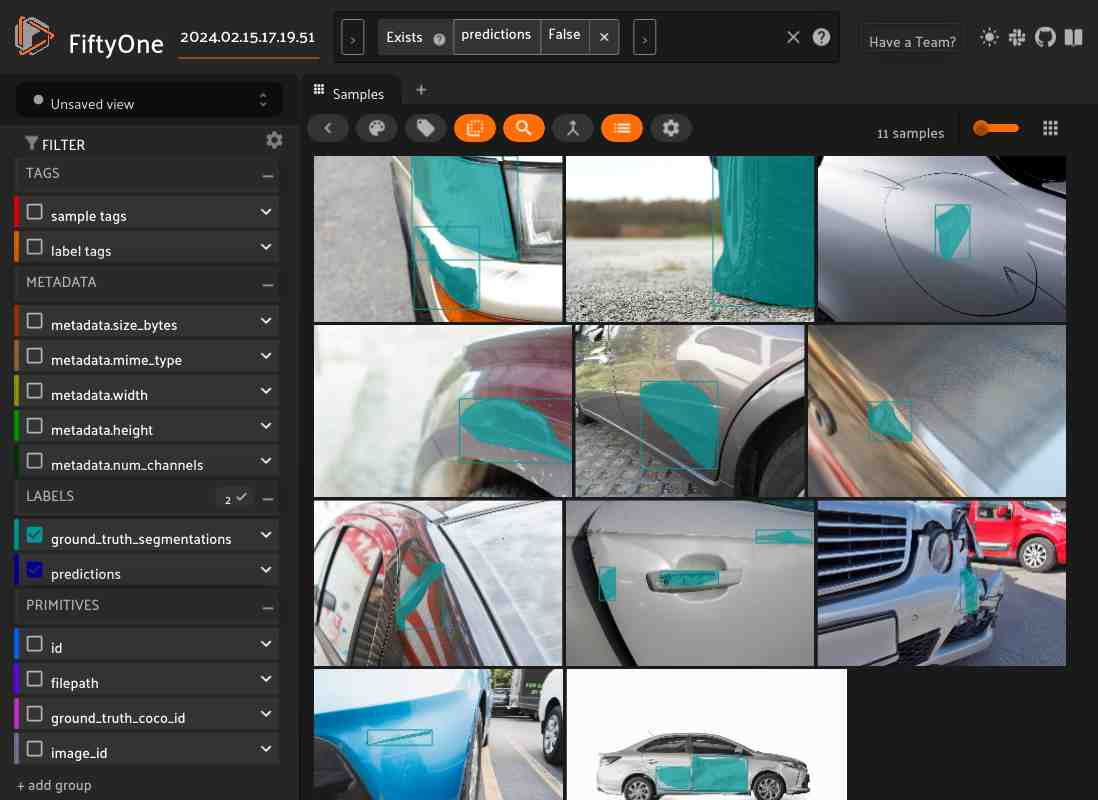

In [27]:
session = fo.launch_app(dataset)

In [28]:
sample = dataset.first()
sample.ground_truth_segmentations

<Detections: {
    'detections': [
        <Detection: {
            'id': '65ce71e7d4ef4488324a07cb',
            'attributes': {},
            'tags': [],
            'label': 'tire flat',
            'bounding_box': [0.03261, 0.331424287856072, 0.33172, 0.4989805097451274],
            'mask': array([[False, False, False, ..., False, False, False],
                   [False, False, False, ..., False, False, False],
                   [False, False, False, ..., False, False, False],
                   ...,
                   [False, False, False, ..., False, False, False],
                   [False, False, False, ..., False, False, False],
                   [False, False, False, ..., False, False, False]]),
            'confidence': None,
            'index': None,
            'iscrowd': 0,
            'occluded': False,
            'area': 85824.71691717155,
        }>,
        <Detection: {
            'id': '65ce71e7d4ef4488324a07cc',
            'attributes': {},
            'ta


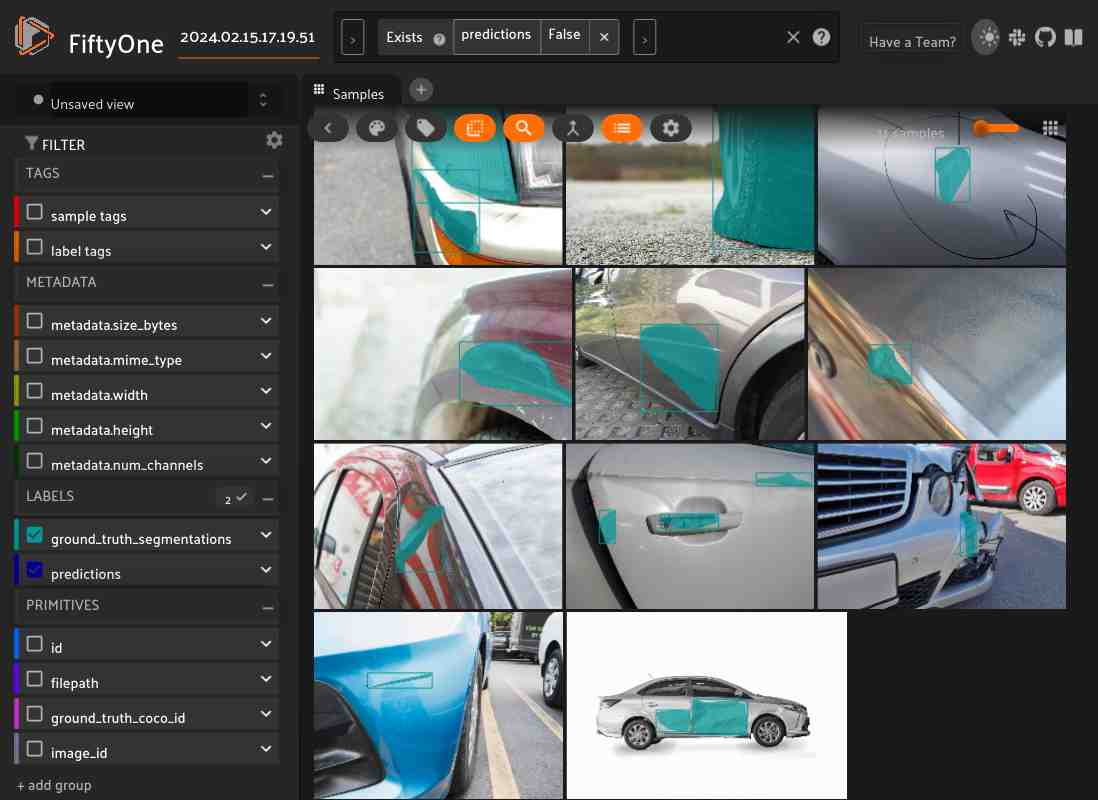

In [29]:
# Exibe imagens que não tiveram nenhum objeto identificado na predição
no_predictions_view = dataset.exists("predictions", False)
session = fo.launch_app(view=no_predictions_view)

## Executa a avaliação dos resultados da segmentação

In [30]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth_segmentations",
    method="coco",
    compute_mAP=True,
    use_masks=True # para avaliar segmentação, usando as máscaras para calcular o IoU
)

Evaluating detections...
 100% |█████████████████| 374/374 [11.0s elapsed, 0s remaining, 38.4 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 374/374 [11.0s elapsed, 0s remaining, 34.4 samples/s]      


In [31]:
print(results.mAP())

0.42945615057179554


In [32]:
plot = results.plot_pr_curves(classes=["crack", "tire flat", "glass shatter", "scratch", "dent", "lamp broken"], iou_thresh=0.5)
plot.update_layout(xaxis_title = "Revocação",yaxis_title = "Precisão")
plot.show()

FigureWidget({
    'data': [{'customdata': array([0.99999332, 0.99999332, 0.99999285, 0.99999142, 0.99999142, 0.99999058,
                                   0.99999034, 0.99999034, 0.99998569, 0.99998105, 0.99998009, 0.99998009,
                                   0.99997318, 0.99997091, 0.99997091, 0.99996758, 0.9999665 , 0.99996173,
                                   0.99996173, 0.99996018, 0.99995375, 0.99995375, 0.99995196, 0.99994755,
                                   0.99994683, 0.99994683, 0.99994099, 0.99993598, 0.99993598, 0.99993491,
                                   0.99993038, 0.99992526, 0.99992526, 0.9999243 , 0.99992239, 0.99992239,
                                   0.99992144, 0.99992073, 0.99992073, 0.99991715, 0.99991083, 0.99990726,
                                   0.99990726, 0.99988985, 0.99988937, 0.99988937, 0.99987483, 0.9998517 ,
                                   0.99985003, 0.99985003, 0.99984396, 0.99982232, 0.99982232, 0.99977201,
                      

## Resultados sem limitar o score de confiança

In [34]:
#matriz de confusão considerando detecções de qualquer confidence score
results_for_confusion = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth_segmentations",
    method="coco",
    compute_mAP=True,
    use_masks=True,
    classwise=False, # com False, objetos preditos podem ser combinados com objetos verdadeiros de diferentes classes,
    eval_key="eval" # para criar e popular campos eval_tp, eval_fp e eval_fn
)
plot = results_for_confusion.plot_confusion_matrix(classes=["crack", "tire flat", "glass shatter", "scratch", "dent", "lamp broken"])
plot.show()

Evaluating detections...
 100% |█████████████████| 374/374 [12.8s elapsed, 0s remaining, 28.8 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 374/374 [10.6s elapsed, 0s remaining, 38.2 samples/s]      


FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',
              'uid': 'b932245d-4280-4bfc-91f5-f3e83d5b9ba6',
              'x': array([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
                          3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5,
                          6]),
              'y': array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
                          3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
                          6])},
             {'colorscale': [[0.0, 'rgb(255,245,235)'], [0.125,
                             'rgb(254,230,206)'], [0.25, 'rgb(253,208,162)'],
                             [0.375, 'rgb(253,174,107)'], [0.5, 'rgb(253,141,60)'],
                             [0.625, 'rgb(241,105,19)'], [0.75, 'rgb(217,72,1)'],
                             [0.875, 'rgb(166,54,3)'], [1.0, 'rgb

In [35]:
#report considerando detecções de qualquer confidence score
results.print_report()

               precision    recall  f1-score   support

        crack       0.31      0.40      0.35        70
         dent       0.60      0.58      0.59       236
glass shatter       0.84      0.93      0.88        71
  lamp broken       0.52      0.68      0.59        69
      scratch       0.45      0.51      0.48       307
    tire flat       0.84      0.84      0.84        32

    micro avg       0.53      0.59      0.56       785
    macro avg       0.59      0.66      0.62       785
 weighted avg       0.54      0.59      0.56       785



In [36]:
# lista atributos do resultado
results.custom_attributes()

['ytrue',
 'ypred',
 'confs',
 'weights',
 'ytrue_ids',
 'ypred_ids',
 'classes',
 'missing',
 'ious',
 'precision',
 'recall',
 'iou_threshs',
 'thresholds']

In [37]:
y_true = results.ytrue
y_pred = results.ypred
classes = results.classes
confs = results.confs

data = pd.DataFrame({'true':y_true, 'pred': y_pred, 'conf': confs})
data

,true,pred,conf
0,tire flat,tire flat,0.9999
1,tire flat,(none),None
2,scratch,scratch,0.789197
3,(none),scratch,0.182533
4,dent,dent,0.778704
...,...,...,...
1185,crack,(none),None
1186,crack,(none),None
1187,(none),tire flat,0.987871
1188,(none),scratch,0.464329


In [38]:
# Fazendo o report com o SKLearn os resultados das classes são os mesmos...
# Mas ele inclui a classe "(none)" no cálculo das médias, que ficam com valores errados
classification_report = skm.classification_report(y_true, y_pred,digits=3, output_dict=False)
print(classification_report)

               precision    recall  f1-score   support

       (none)      0.000     0.000     0.000       405
        crack      0.315     0.400     0.352        70
         dent      0.601     0.581     0.591       236
glass shatter      0.835     0.930     0.880        71
  lamp broken      0.522     0.681     0.591        69
      scratch      0.450     0.511     0.479       307
    tire flat      0.844     0.844     0.844        32

     accuracy                          0.388      1190
    macro avg      0.510     0.564     0.534      1190
 weighted avg      0.357     0.388     0.371      1190



In [39]:
# Função para obter o valor da precisão média correto, sem incluir classe 'none' no cálculo
def metric_macro_avg(y_true, y_pred, metric):
    classification_report_dict = skm.classification_report(y_true, y_pred,digits=3, output_dict=True)
    classes=["crack", "tire flat", "glass shatter", "scratch", "dent", "lamp broken"]
    metric_sum = 0.0
    for category in classes:
        metric_sum = metric_sum + classification_report_dict[category][metric]
        metric_macro_avg = metric_sum / 6
    return metric_macro_avg

In [40]:
print('Precision macro avg: ', metric_macro_avg(y_true, y_pred, 'precision'))
print('Recall macro avg: ', metric_macro_avg(y_true, y_pred, 'recall'))
print('F1-Score macro avg: ', metric_macro_avg(y_true, y_pred, 'f1-score'))

Precision macro avg:  0.5944593213794586
Recall macro avg:  0.6577326685201094
F1-Score macro avg:  0.6227203340632951


## Distribuição do score de confiança

In [41]:
confidence_scores = results.confs
confidence_scores

array([0.9999004602432251, None, 0.7891969680786133, ...,
       0.9878705143928528, 0.46432918310165405, 0.13175451755523682],
      dtype=object)

In [42]:
len(confidence_scores)

1190

In [43]:
# Remove os scores com valor None
# (os elementos com valor None são referentes a objetos que existiam no ground truth mas não foram detectados)
confidence_scores = confidence_scores[confidence_scores != None]
print('Instânias preditas (considerando IoU=0.50): ' + str(len(confidence_scores)))

Instânias preditas (considerando IoU=0.50): 867


In [44]:
scores_df = pd.DataFrame({'score de confiança': confidence_scores})
scores_df

,score de confiança
0,0.9999
1,0.789197
2,0.182533
3,0.778704
4,0.994787
...,...
862,0.999991
863,0.983858
864,0.987871
865,0.464329


In [45]:
import altair as alt

alt.Chart(scores_df).mark_bar().encode(
    alt.X("score de confiança:Q").bin(maxbins=20).title("Score de confiança"),
    alt.Y("count()", title="Quantidade de instâncias")
)

alt.Chart(...)

## Análise das detecções por limiar de score de confiança

In [46]:
data

,true,pred,conf
0,tire flat,tire flat,0.9999
1,tire flat,(none),None
2,scratch,scratch,0.789197
3,(none),scratch,0.182533
4,dent,dent,0.778704
...,...,...,...
1185,crack,(none),None
1186,crack,(none),None
1187,(none),tire flat,0.987871
1188,(none),scratch,0.464329


In [47]:
def calculate_metrics(data, conf_threshold):
    data_copy = data.copy()
    data_copy.loc[(data_copy.conf < conf_threshold) & (data_copy.true != '(none)'), "pred"] = '(none)'
    data_copy.loc[(data_copy.conf < conf_threshold) & (data_copy.true != '(none)'), "conf"] = None
    data_conf_over_thr = data_copy[(data_copy.conf > conf_threshold) | (data_copy.conf.isna())]
    precision_macro_avg = metric_macro_avg(data_conf_over_thr['true'], data_conf_over_thr['pred'], 'precision')
    recall_macro_avg = metric_macro_avg(data_conf_over_thr['true'], data_conf_over_thr['pred'], 'recall')
    f1_score_macro_avg = metric_macro_avg(data_conf_over_thr['true'], data_conf_over_thr['pred'], 'f1-score')
    return conf_threshold, precision_macro_avg, recall_macro_avg, f1_score_macro_avg

In [48]:
def print_metrics(data, conf_threshold):
    data_copy = data.copy()
    data_copy.loc[(data_copy.conf < conf_threshold) & (data_copy.true != '(none)'), "pred"] = '(none)'
    data_copy.loc[(data_copy.conf < conf_threshold) & (data_copy.true != '(none)'), "conf"] = None
    data_conf_over_thr = data_copy[(data_copy.conf > conf_threshold) | (data_copy.conf.isna())]
    classification_report = skm.classification_report(data_conf_over_thr['true'], data_conf_over_thr['pred'],digits=3, output_dict=False)
    precision_macro_avg = metric_macro_avg(data_conf_over_thr['true'], data_conf_over_thr['pred'], 'precision')
    recall_macro_avg = metric_macro_avg(data_conf_over_thr['true'], data_conf_over_thr['pred'], 'recall')
    f1_score_macro_avg = metric_macro_avg(data_conf_over_thr['true'], data_conf_over_thr['pred'], 'f1-score')
    print(classification_report)
    print('Precision macro avg: ', precision_macro_avg)
    print('Recall macro avg: ', recall_macro_avg)
    print('F1-score macro avg: ', f1_score_macro_avg)

In [49]:
resultados_geral = []
for conf_threshold in [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.96, 0.97, 0.98, 0.99]:
    conf_thr, precision, recall, f1_score = calculate_metrics(data, conf_threshold)
    resultados_geral.append([conf_thr, precision, recall, f1_score])
resultados_geral

[[0.0, 0.5944593213794586, 0.6577326685201094, 0.6227203340632951],
 [0.1, 0.630536340547512, 0.6357519818327819, 0.6316912245243278],
 [0.2, 0.6732946934083456, 0.6206543661704745, 0.6437472479189594],
 [0.3, 0.6943761178876743, 0.6065964536416705, 0.6433513376652307],
 [0.4, 0.7075880183852791, 0.5950000732466371, 0.6413773475859119],
 [0.5, 0.7232836106330082, 0.5891639587949834, 0.6438642916701239],
 [0.6, 0.7367749801349839, 0.5869924061348314, 0.6457626867639382],
 [0.7, 0.7509465672089543, 0.5794056426158645, 0.6445346892841634],
 [0.8, 0.7574410751018084, 0.5529851663352784, 0.6283319205254508],
 [0.9, 0.7730923206386624, 0.5303433661395894, 0.6164800004759964],
 [0.95, 0.7892125310321737, 0.5088139697656182, 0.6026608023390531],
 [0.96, 0.7995763300855486, 0.5029317821173918, 0.5990473549245975],
 [0.97, 0.7967802640164526, 0.49461942985738067, 0.5913917554555875],
 [0.98, 0.8042195354220341, 0.48294720095407345, 0.5830075775606046],
 [0.99, 0.8569353667392884, 0.4749799037786

In [50]:
resultados_geral_df = pd.DataFrame(resultados_geral, columns=['Limiar de confiança', 'Precisão', 'Revocação', 'F1-score'])
colunas_metricas = ['Precisão', 'Revocação', 'F1-score']
resultados_geral_df[colunas_metricas] = resultados_geral_df[colunas_metricas]*100
resultados_geral_df[colunas_metricas] = resultados_geral_df[colunas_metricas].round(1)
resultados_geral_df

,Limiar de confiança,Precisão,Revocação,F1-score
0,0.00,59.4,65.8,62.3
1,0.10,63.1,63.6,63.2
2,0.20,67.3,62.1,64.4
3,0.30,69.4,60.7,64.3
4,0.40,70.8,59.5,64.1
5,0.50,72.3,58.9,64.4
6,0.60,73.7,58.7,64.6
7,0.70,75.1,57.9,64.5
8,0.80,75.7,55.3,62.8
9,0.90,77.3,53.0,61.6


### Detecções com confidence >= 0.70

In [51]:
# Only include predictions with `confidence` of at least 0.70
predictions_filtered_view = dataset.set_field(
    "predictions.detections",
    F("detections").filter(F("confidence") > 0.70)
)

In [52]:
results_predictions_over_70 = predictions_filtered_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth_segmentations",
    method="coco",
    compute_mAP=True,
    use_masks=True,
    eval_key="eval" # para criar e popular campos eval_tp, eval_fp e eval_fn
)
results_predictions_over_70.print_report(digits=3)

Evaluating detections...
 100% |█████████████████| 374/374 [10.0s elapsed, 0s remaining, 37.2 samples/s]     
Performing IoU sweep...
 100% |█████████████████| 374/374 [8.0s elapsed, 0s remaining, 51.0 samples/s]      
               precision    recall  f1-score   support

        crack      0.429     0.171     0.245        70
         dent      0.761     0.500     0.604       236
glass shatter      0.957     0.930     0.943        71
  lamp broken      0.705     0.623     0.662        69
      scratch      0.726     0.440     0.548       307
    tire flat      0.929     0.812     0.867        32

    micro avg      0.759     0.510     0.610       785
    macro avg      0.751     0.579     0.645       785
 weighted avg      0.737     0.510     0.596       785



# Visualização

## Todo o ground truth e instâncias preditas acima do limiar de 0.70

In [53]:
session = fo.launch_app(view=predictions_filtered_view)

## Apenas imagens com instâncias pequenas

In [54]:
# exibe apenas anotações com área de máscara pequena (menor que 1024 pixels). Imagens que não tenham anotações pequenas não entram nessa view
view = predictions_filtered_view.filter_labels("ground_truth_segmentations.detections", F("area") < 1024)

# caso queira exibir todas as anotações dessas imagens, usar esse código comentado
# filter = F("area") < 1024
# view = dataset.match_labels(filter=filter, fields="ground_truth_segmentations")

session = fo.launch_app(view=view)

In [55]:
predictions_filtered_view

Dataset:     2024.02.15.17.19.51
Media type:  image
Num samples: 374
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_coco_id:       fiftyone.core.fields.IntField
    image_id:                   fiftyone.core.fields.IntField
    predictions:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:                    fiftyone.core.fields.IntField
    eval_fp:                    fiftyone.core.fields.IntField
    eval_fn:                    fiftyone.core.fields.IntField
View stages:
    1. SetField(field='predictions.

## Outras visualizações

Usando evaluation patches transformamos o dataset (ou view) em uma nova visualização que contém uma amostra para cada verdadeiro positivo, falso positivo e falso negativo.

In [56]:
# Converte para evaluation patches
eval_patches = predictions_filtered_view.to_evaluation_patches("eval")
print(eval_patches)

print(eval_patches.count_values("type"))

session.view = eval_patches

Dataset:     2024.02.15.17.19.51
Media type:  image
Num patches: 912
Patch fields:
    id:                         fiftyone.core.fields.ObjectIdField
    sample_id:                  fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    predictions:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:                      fiftyone.core.fields.BooleanField
    type:                       fiftyone.core.fields.StringField
    iou:                        fiftyone.core.fields.FloatField
View stages:
    1. SetField(field='predictions.detections', expr={'$filter': {'as': 'this', 'con

In [57]:
# Crie primeiro uma view em ordem decrescente no numero de falsos positivos na imagem e
# filtra para somente exibir predições falso positivas
view = (
    predictions_filtered_view
    .sort_by("eval_fp", reverse=True)
    .filter_labels("predictions", F("eval") == "fp")
)